In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import json
from flask import jsonify

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
#reflect database
Base = automap_base()
#reflect tables
Base.prepare(engine, reflect=True)

In [7]:
#view reflected table names
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#query for dates and find latest
latestDate = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())

#extract string from query object
latestDate = list(np.ravel(latestDate))[0]
#convert date string to datetime object
latestDate = dt.datetime.strptime(latestDate, '%Y-%m-%d')

#extract year, month, and day as integers
latestYear = int(dt.datetime.strftime(latestDate, '%Y'))
latestMonth = int(dt.datetime.strftime(latestDate, '%m'))
latestDay = int(dt.datetime.strftime(latestDate, '%d'))

#calculate one year before latest date
yearBefore = dt.date(latestYear, latestMonth, latestDay) - dt.timedelta(days=365)

#query for dates and precipitation for the latest year
rainData = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > yearBefore)
                  .order_by(Measurement.date)
                  .all())

#convert query object to data frame and set index
rainTable = pd.DataFrame(rainData)
rainTable = rainTable.set_index('date')

rainTable.head(30)



,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08


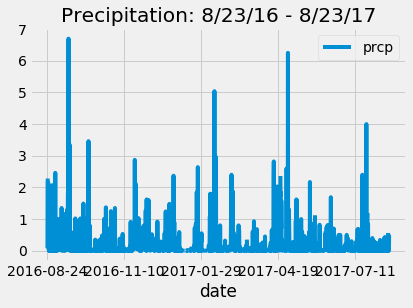

In [11]:
#sort by date
rainTable = rainTable.sort_index(ascending=True)

#plot with pandas
rainTable.plot(title="Precipitation: 8/23/16 - 8/23/17")


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rainTable.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.id).distinct().count()
stations

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationCounts = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
stationCounts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
#set the most active station
stationID = stationCounts[0][0]

#query for station name
stationName = (session.query(Station.name).filter_by(station = stationID))
stationName = stationName[0][0]
print(f"The most active station is {stationID}: {stationName}.")

#query for highest temperature
highestTemp = (session.query(Measurement.tobs).filter(Measurement.station == stationID).order_by(Measurement.tobs.desc()).first())
highestTemp = highestTemp[0]
print(f"The highest temperature recorded is {highestTemp} degrees Farenheit.")

#query for lowest temperature
lowestTemp = (session.query(Measurement.tobs).filter(Measurement.station == stationID).order_by(Measurement.tobs.asc()).first())
lowestTemp = lowestTemp[0]
print(f"The lowest temperature recorded is {lowestTemp} degrees Farenheit.")

#query for average temperature
avgTemp = (session.query(func.avg(Measurement.tobs)).filter(Measurement.station == stationID))
avgTemp = '{0:.3}'.format(avgTemp[0][0])
print(f"The averages {avgTemp} degrees Farenheit.")

The most active station is USC00519281: WAIHEE 837.5, HI US.
The highest temperature recorded is 85.0 degrees Farenheit.
The lowest temperature recorded is 54.0 degrees Farenheit.
The averages 71.7 degrees Farenheit.


            tobs
date            
2016-08-24  77.0
2016-08-25  80.0
2016-08-26  80.0
2016-08-27  75.0
2016-08-28  73.0
...          ...
2017-08-14  77.0
2017-08-15  77.0
2017-08-16  76.0
2017-08-17  76.0
2017-08-18  79.0

[351 rows x 1 columns]


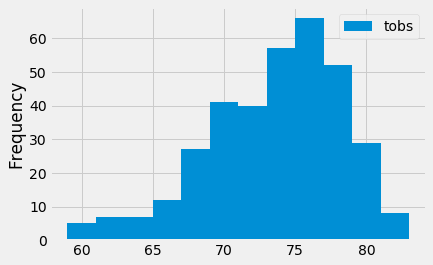

In [17]:
#query for the last year of temperature data
tempData = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > yearBefore)
                   .filter(Measurement.station == stationID)
                   .order_by(Measurement.date)
                   .all())

#convert query object to data frame
tempTable = pd.DataFrame(tempData)
tempTable = tempTable.set_index('date')

#sory by date
tempTable = tempTable.sort_index(ascending=True)
print(tempTable)
#histogram plot with pandas
tempTable.plot(kind='hist', bins=12)

## Bonus Challenge Assignment

In [18]:
#June Data
June=session.query(Measurement.tobs, Measurement.date).\
        filter(Measurement.date == '%%%%-06-%%').all()

#convert query object to data frame and set index
JuneTable = pd.DataFrame(June)

JuneTable.head(30)

""


In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-01-30', '2012-02-30'))


[(56.0, 69.29752066115702, 78.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2010-01-30', '2011-02-30'))

[(56.0, 72.14668409016662, 87.0)]


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
